In [373]:
# imports MatLab packages
import numpy as np
import matplotlib.pyplot as plt

# imports Gaussian Processes package
import GPy

# imports randomization package
import random

# imports math package
import math

# imports mean squared error
from sklearn.metrics import mean_squared_error

# imports time
import time

In [374]:
# defintion of plotting utility to plot a GP fit with 95% confidence interval

def plot_gp(X, m, C, training_points = None):
    
    # plot 95% confidence interval 
    plt.fill_between(X[:, 0],
                     m[:, 0] - 1.96 * np.sqrt(np.diag(C)),
                     m[:, 0] + 1.96 * np.sqrt(np.diag(C)),
                     alpha = 0.5)
    
    # plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels = ["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels = ["GP fit", "sample points"])

In [375]:
# defintion of function
# sin(x - 0.25) + 0.7cos(x + 0.4x) + random_number

def f(x):
    return np.sin(x - 0.25) + 0.7 * np.cos(x + 0.4 * x) + np.random.normal(0.0, 0.5, x.shape)

In [376]:
# creates x-axis of plot
# initial: 0.0, final: 11.0, interval: 0.1

x1 = np.arange(0.0, 11.0, 0.1)[:, None]

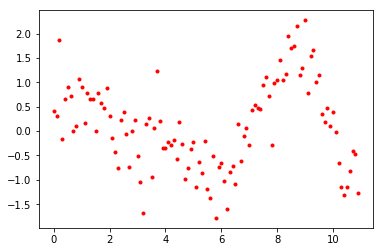

In [377]:
# prints plot

plt.plot(x1, f(x1), 'r.')
plt.show()

In [378]:
# creates GP kernel
# optimizes GP regression

k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(x1, f(x1), k)
m.optimize()

In [379]:
# establishes mean, covariance, variance of plot

mean, Cov = m.predict(x1, full_cov = True)
mean, variance = m.predict(x1)

GP_regression.,value,constraints,priors
rbf.variance,0.8434146267622161,+ve,
rbf.lengthscale,1.2762427266733538,+ve,
Gaussian_noise.variance,0.24849603659282218,+ve,


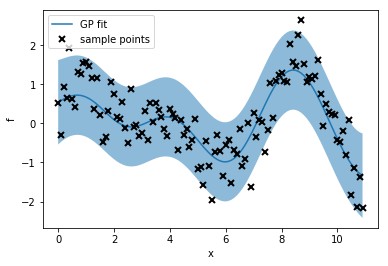

In [380]:
# prints mean, covariance
# prints GP regression plot

plot_gp(x1, mean, Cov, training_points = (x1, f(x1)))
m

# START QUESTIONABLE PART OF THE CODE

In [381]:
# performs GP regression algorithm

def GP_regression(measured_samples, total_samples, unmeasured_samples):
    
    # creates GP kernel
    # optimizes GP regression
    k2 = GPy.kern.RBF(1)
    m2 = GPy.models.GPRegression(measured_samples[:,0][:,None], measured_samples[:,1][:,None], k2)
    m2.optimize()

    # establishes mean, covariance, variance of plot
    mean, covariance = m2.predict(total_samples[:,0][:,None], full_cov = True)
    mean, variance = m2.predict(total_samples[:,0][:,None])
    mean_unmeasured, variance_unmeasured = m2.predict(unmeasured_samples[:,0][:,None])
    mean_measured, variance_measured = m2.predict(measured_samples[:,0][:,None])

    # print mean, covariance
    # print GP regression plot
    # plot_gp(total_samples[:,0][:,None], mean, covariance, training_points = (measured_samples[:,0], measured_samples[:,1]))
    # plt.show()
    return m2, mean_unmeasured, variance_unmeasured, mean # GP regression information

In [382]:
var_lambda = 0.1

In [383]:
# grabs index of maximum upper confidence bound for unmeasured_samples

def get_upper_confidence_index(mean_unmeasured, variance_unmeasured, iteration):
    beta = 2 * math.log(len(total_samples) * math.pow(iteration, 2) * math.pow(math.pi, 2) / (6 * var_lambda))
    alpha = mean_unmeasured + math.sqrt(beta) * variance_unmeasured
    
    return alpha.argmax() # integer index

In [384]:
# calculates mean squared error

def get_mean_squared_error(predicted_values, measured_values):
    mean_values = np.mean(np.square(np.subtract(predicted_values, measured_values)))
    return math.sqrt(mean_values) # float

In [385]:
# plots mean squared error

def plot_mean_squared_error(iteration, mean_squared_error):
    plt.title("Mean Squared Error")
    plt.xlabel("Iteration")
    plt.ylabel("Mean Squared Error")
    plt.plot(iteration, mean_squared_error)
    plt.show()

In [386]:
# sampling from the GP

k = GPy.kern.RBF(input_dim = 1, lengthscale = 0.2)

X = np.linspace(0., 1., 500) # 500 points evenly spread over [0, 1]
X = X[:, None] # reshape X to make it n * p

mu = np.zeros((500)) # vector of the means
C = k.K(X, X) # covariance matrix associated with inputs X

# generate 20 separate samples from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu, C, 1)

In [398]:
row_iteration_counter = 0 # total rows of matrix

In [399]:
row_iteration_total = 5

columns_total = 101

In [400]:
mean_squared_error_array_total = np.zeros(shape = (row_iteration_total, columns_total))

In [401]:
while row_iteration_counter < 5:

    unmeasured_samples = x1
    measured_samples = [] # empty array

    # plot 10 random (prior) points

    # establish all samples to be measured
    y1 = f(x1)
    total_samples = np.hstack((x1, y1))
    unmeasured_samples = total_samples;

    # take 10 random samples
    L = np.shape(x1)[0]
    indices_to_keep = np.random.permutation(L)[0:10] # randomizes all samples
    measured_samples = unmeasured_samples[indices_to_keep, :]
    unmeasured_samples = np.delete(unmeasured_samples, indices_to_keep, 0)

    # builds plot
    plt.title("Initial Random Samples")
    plt.plot(measured_samples[:, 0], measured_samples[:, 1], 'r.')
    plt.show()

    iteration_counter_1 = 1 # initialized to 1 to account for logarithmic function

    iteration_counter_0_array = None # typical iteration counter

    mean_squared_error_array = None

    # performs GP regression for all elements in unmeasured_samples

    while unmeasured_samples.size > 0:

        # prints regression plot and measures of central tendency
        m2, mean_unmeasured, variance_unmeasured, mean_total = GP_regression(measured_samples, total_samples, unmeasured_samples)

        # gets new maximum upper confidence bound on every loop
        upper_confidence_index = get_upper_confidence_index(mean_unmeasured, variance_unmeasured, iteration_counter_1)
        upper_confidence_xy = np.array([unmeasured_samples[upper_confidence_index]]) # x- and y-values (two columns)

        # adds value with maximum upper confidence bound to measured_samples
        # deletes value with maximum upper confidence bound from unmeasured_samples
        measured_samples = np.concatenate((measured_samples, upper_confidence_xy))
        unmeasured_samples = np.delete(unmeasured_samples, upper_confidence_index, 0)

        # gets mean squared error
        mean_squared_error = get_mean_squared_error(mean_total, total_samples[:, 1][:, None])
        mean_squared_error_array = np.append(mean_squared_error_array, mean_squared_error) # array of all mean squared errors
        
        iteration_counter_0_array = np.append(iteration_counter_0_array, iteration_counter_1 - 1) # tallies iterations
        iteration_counter_1 = iteration_counter_1 + 1
        
    mean_squared_error_array_total[row_iteration_counter] = mean_squared_error_array
    
    row_iteration_counter = row_iteration_counter + 1

In [402]:
column_iteration_counter = 1

In [403]:
column_sum = 0

In [404]:
mean_squared_error_array_mean = np.zeros(shape = (1, row_iteration_total))

In [405]:
while column_iteration_counter < 6:
    for item in mean_squared_error_array_total:  
        column_sum = column_sum + item[column_iteration_counter]

    column_mean = column_sum / 5
    
    mean_squared_error_array_mean[:, column_iteration_counter - 1] = column_mean
    
    column_iteration_counter = column_iteration_counter + 1

In [406]:
print(mean_squared_error_array_mean)

[[0.81776492 1.539132   2.21654812 2.88588162 3.53985378]]
